In [10]:
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
"""
Comprehensive PyTorch Environment Checker

This script prints detailed information about the current Python and PyTorch environment,
including system information, PyTorch and TorchVision versions, CUDA and cuDNN support,
GPU properties, and installation method. Use this script to quickly diagnose and share
your runtime configuration for debugging or reproducibility.

Author: Alex Deng
Date: 2025-07-08
"""

import sys
import torch
import torchvision
import platform
import subprocess
import warnings
warnings.filterwarnings(
    "ignore", 
    category=FutureWarning,
    message="Importing from timm.models.layers is deprecated, please import via timm.layers"
)
def comprehensive_pytorch_check():
    print("=" * 60)
    print("Comprehensive PyTorch Environment Check")
    print("=" * 60)
    
    # System Information
    print("\n=== System Information ===")
    print(f"Operating System: {platform.system()} {platform.release()}")
    print(f"Python Version: {sys.version}")
    print(f"Architecture: {platform.machine()}")
    
    # PyTorch Information
    print("\n=== PyTorch Information ===")
    print(f"PyTorch Version: {torch.__version__}")
    print(f"TorchVision Version: {torchvision.__version__}")
    print(f"PyTorch Git Version: {torch.version.git_version}")
    print(f"PyTorch Debug Mode: {torch.version.debug}")
    
    # CUDA Information
    print("\n=== CUDA Information ===")
    print(f"PyTorch CUDA Version: {torch.version.cuda}")
    print(f"CUDA Available: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        print(f"Number of CUDA Devices: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            props = torch.cuda.get_device_properties(i)
            print(f"  GPU {i}: {props.name}")
            print(f"    Memory: {props.total_memory / 1024**3:.1f} GB")
            print(f"    Compute Capability: {props.major}.{props.minor}")
    
    # cuDNN Information
    print("\n=== cuDNN Information ===")
    if torch.backends.cudnn.is_available():
        print(f"cuDNN Version: {torch.backends.cudnn.version()}")
        print(f"cuDNN Enabled: {torch.backends.cudnn.enabled}")
        print(f"cuDNN Benchmark: {torch.backends.cudnn.benchmark}")
        print(f"cuDNN Deterministic: {torch.backends.cudnn.deterministic}")
    else:
        print("cuDNN not available")
    
    # Attention Mechanism Support
    print("\n=== Attention Mechanism Support ===")
    try:
        print(f"Flash Attention: {torch.backends.cuda.flash_sdp_enabled()}")
        print(f"Memory Efficient: {torch.backends.cuda.mem_efficient_sdp_enabled()}")
        print(f"Math SDP: {torch.backends.cuda.math_sdp_enabled()}")
    except:
        print("Unable to check attention mechanism support")
    
    # Installation Information
    print("\n=== Installation Information ===")
    try:
        result = subprocess.run([sys.executable, "-m", "pip", "show", "torch"], 
                              capture_output=True, text=True)
        if result.returncode == 0:
            lines = result.stdout.split('\n')
            for line in lines[:6]:  # Show the first several lines of important info
                if line.strip():
                    print(line)
    except:
        print("Unable to retrieve pip installation info")

# Run the check
comprehensive_pytorch_check()

Comprehensive PyTorch Environment Check

=== System Information ===
Operating System: Windows 10
Python Version: 3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:42:04) [MSC v.1943 64 bit (AMD64)]
Architecture: AMD64

=== PyTorch Information ===
PyTorch Version: 2.4.0
TorchVision Version: 0.19.0
PyTorch Git Version: e4ee3be4063b7c430974252fdf7db42273388d86
PyTorch Debug Mode: False

=== CUDA Information ===
PyTorch CUDA Version: 12.1
CUDA Available: True
Number of CUDA Devices: 1
  GPU 0: NVIDIA GeForce RTX 4090
    Memory: 24.0 GB
    Compute Capability: 8.9

=== cuDNN Information ===
cuDNN Version: 90100
cuDNN Enabled: True
cuDNN Benchmark: False
cuDNN Deterministic: False

=== Attention Mechanism Support ===
Flash Attention: True
Memory Efficient: True
Math SDP: True

=== Installation Information ===
Name: torch
Version: 2.4.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-emai

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import os

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='#FF8585', facecolor=(0, 0, 0, 0), lw=3))
    
    
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [3]:
import warnings
import os
import cv2  # or use PIL
import numpy as np

def yolo_to_xyxy(yolo_bbox, img_width, img_height):
    """
    Convert YOLO format to xyxy format.
    yolo_bbox: (class_id, x_center, y_center, width, height)
    img_width: image width
    img_height: image height
    """
    class_id, x_center, y_center, width, height = yolo_bbox
    x_center, y_center, width, height = float(x_center), float(y_center), float(width), float(height)
    
    # Convert to xyxy
    x_min = int((x_center - width / 2) * img_width)
    y_min = int((y_center - height / 2) * img_height)
    x_max = int((x_center + width / 2) * img_width)
    y_max = int((y_center + height / 2) * img_height)
    
    return class_id, x_min, y_min, x_max, y_max

def read_images_and_labels(root_path, data_name, type_T):
    """
    Read all images and their YOLO-format label files, and convert bounding boxes to xyxy format.

    Args:
        root_path: Root directory of the dataset.
        data_name: Name of the dataset.
        type_T: Data split type ('train', 'val', or 'test').

    Returns:
        data_dict: Dictionary mapping image paths to lists of bounding boxes in xyxy format.
    """
    images_path = os.path.join(root_path, data_name, type_T, 'images')
    labels_path = os.path.join(root_path, data_name, type_T, 'labels')

    data_dict = {}

    # Traverse the images folder
    for image_name in os.listdir(images_path):
        if image_name.endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff')):
            image_path = os.path.join(images_path, image_name)
            
            # Read image
            img = cv2.imread(image_path)
            if img is None:
                continue
            img_height, img_width = img.shape[:2]

            # Use os.path.splitext() to get filename and replace with .txt
            base_name = os.path.splitext(image_name)[0]  # Get filename without extension
            label_name = base_name + '.txt'  # Add .txt extension
            label_path = os.path.join(labels_path, label_name)

            # Read label file
            if os.path.exists(label_path):
                with open(label_path, 'r') as file:
                    bboxes = []
                    for line in file.readlines():
                        yolo_bbox = line.strip().split()
                        class_id, x_min, y_min, x_max, y_max = yolo_to_xyxy(yolo_bbox, img_width, img_height)
                        bboxes.append([x_min, y_min, x_max, y_max])

                # Store image path and corresponding xyxy coordinates in the dictionary
                data_dict[image_path] = bboxes

    return data_dict

data_cls = ['Intestine', 'brain', 'colon', 'PDAC']
data_name = data_cls[0]
root_path = r'datasets'

print(root_path)
out_dict = read_images_and_labels(root_path, data_name, type_T='train')

datasets


In [4]:
out_dict

{'datasets\\Intestine\\train\\images\\0002_1141294_ckm3hgcub0fyg345zcgc2fous_img.jpg': [[360,
   805,
   407,
   872],
  [475, 779, 498, 805],
  [107, 660, 132, 680],
  [295, 305, 383, 377],
  [508, 464, 536, 492],
  [62, 546, 109, 632],
  [680, 627, 702, 650],
  [485, 959, 543, 1014],
  [560, 581, 585, 604],
  [410, 366, 446, 399],
  [608, 724, 707, 776],
  [790, 207, 809, 226],
  [159, 768, 193, 803],
  [540, 286, 583, 334],
  [812, 199, 833, 227],
  [398, 910, 430, 952],
  [516, 682, 547, 718],
  [280, 366, 310, 392],
  [638, 379, 660, 401],
  [363, 272, 423, 325],
  [301, 607, 317, 624],
  [687, 218, 707, 235],
  [277, 457, 295, 464],
  [552, 386, 572, 406],
  [211, 275, 231, 296],
  [320, 373, 350, 408],
  [824, 559, 840, 574],
  [775, 593, 801, 636],
  [755, 172, 791, 204],
  [597, 430, 623, 454],
  [293, 935, 352, 984],
  [402, 442, 417, 458],
  [441, 0, 497, 39],
  [737, 101, 754, 118],
  [727, 641, 766, 692],
  [231, 267, 269, 296],
  [389, 744, 479, 825],
  [645, 168, 694, 21

In [5]:
img_path=list(out_dict.keys())

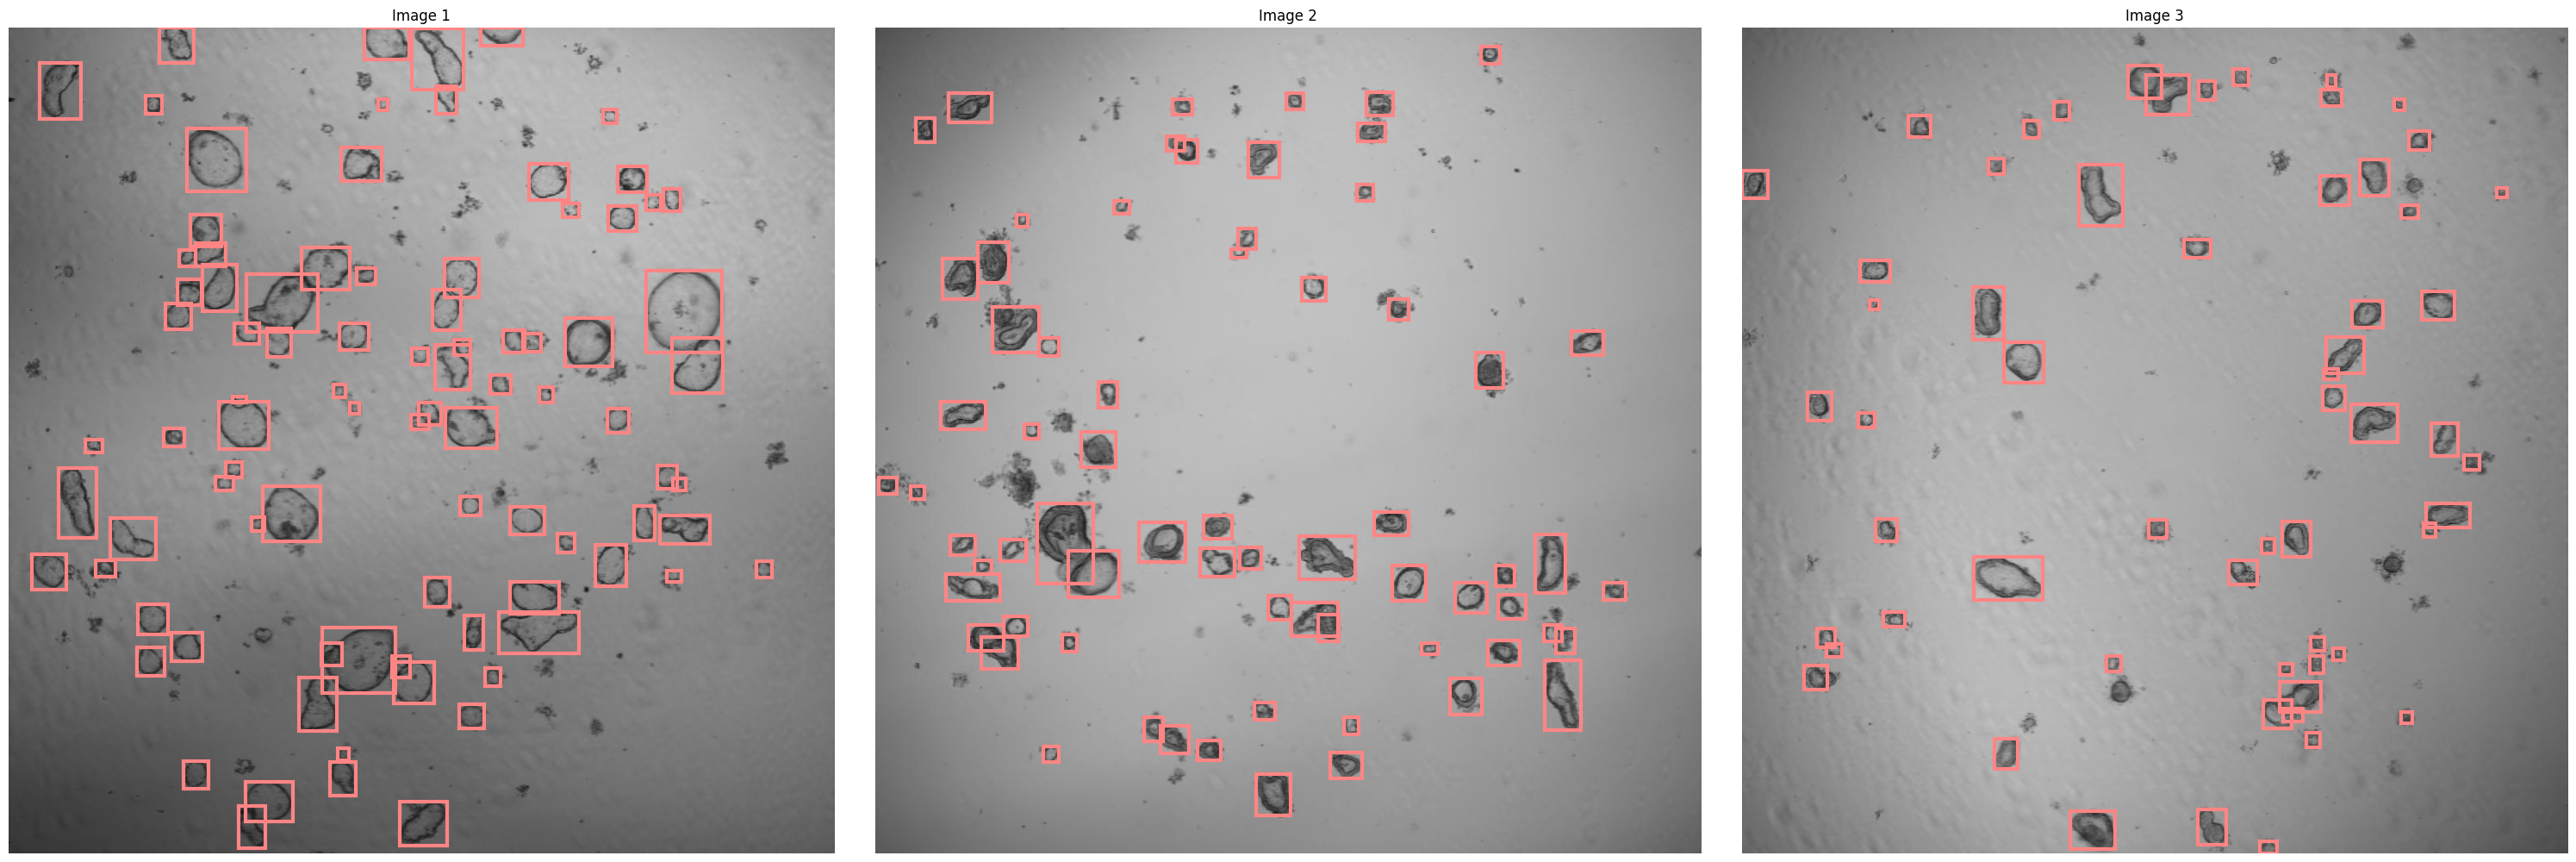

In [8]:
"""
Visualization Script for Bounding Box Detection Results

This script reads the first three sample images, parses their bounding boxes,
and visualizes the images with bounding boxes overlaid using matplotlib.
It assumes that bounding boxes are provided in the `out_dict` dictionary
in xyxy format, and that `show_box` is a function for drawing boxes on matplotlib axes.

Requirements:
- img_path: list of image file paths
- out_dict: dictionary mapping image file paths to lists of bounding boxes
- show_box: function to draw a single bounding box on a matplotlib axis
"""

import torch
device = "cuda"
import cv2
import matplotlib.pyplot as plt

# Create horizontal subplot layout
fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # 1 row, 3 columns

for idx, image_file in enumerate(img_path[:3]):  # Test only first 3 images
    # Read image using cv2
    img = cv2.imread(image_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_boxes = []
    
    for line in out_dict.get(image_file):
        # Parse each label entry into a tensor
        label_data = line
        input_boxes.append(torch.tensor(label_data, device=device))
    
    input_boxes = torch.stack(input_boxes, dim=0)
    
    # Display image on corresponding subplot
    axes[idx].imshow(img)
    for box in input_boxes:
        show_box(box.cpu().numpy(), axes[idx])
    
    axes[idx].axis('off')
    axes[idx].set_title(f'Image {idx+1}')  # Optional: add title

# Adjust spacing between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)  # Adjust horizontal spacing between subplots

plt.show()

Found 184 images with annotations

Processing Image 1: 0002_1141294_ckm3hgcub0fyg345zcgc2fous_img.jpg
  Original instances: 89 -> Filtered instances: 89
  Final boxes: 89

Processing Image 2: 0002_1400272_cknohk6hx30723q67t8a4g2a4_img.jpg
  Original instances: 67 -> Filtered instances: 67
  Final boxes: 67

Processing Image 3: 0002_1460448_cknrg4y5x354f345zv2xb6neu_img.jpg
  Original instances: 59 -> Filtered instances: 59
  Final boxes: 59


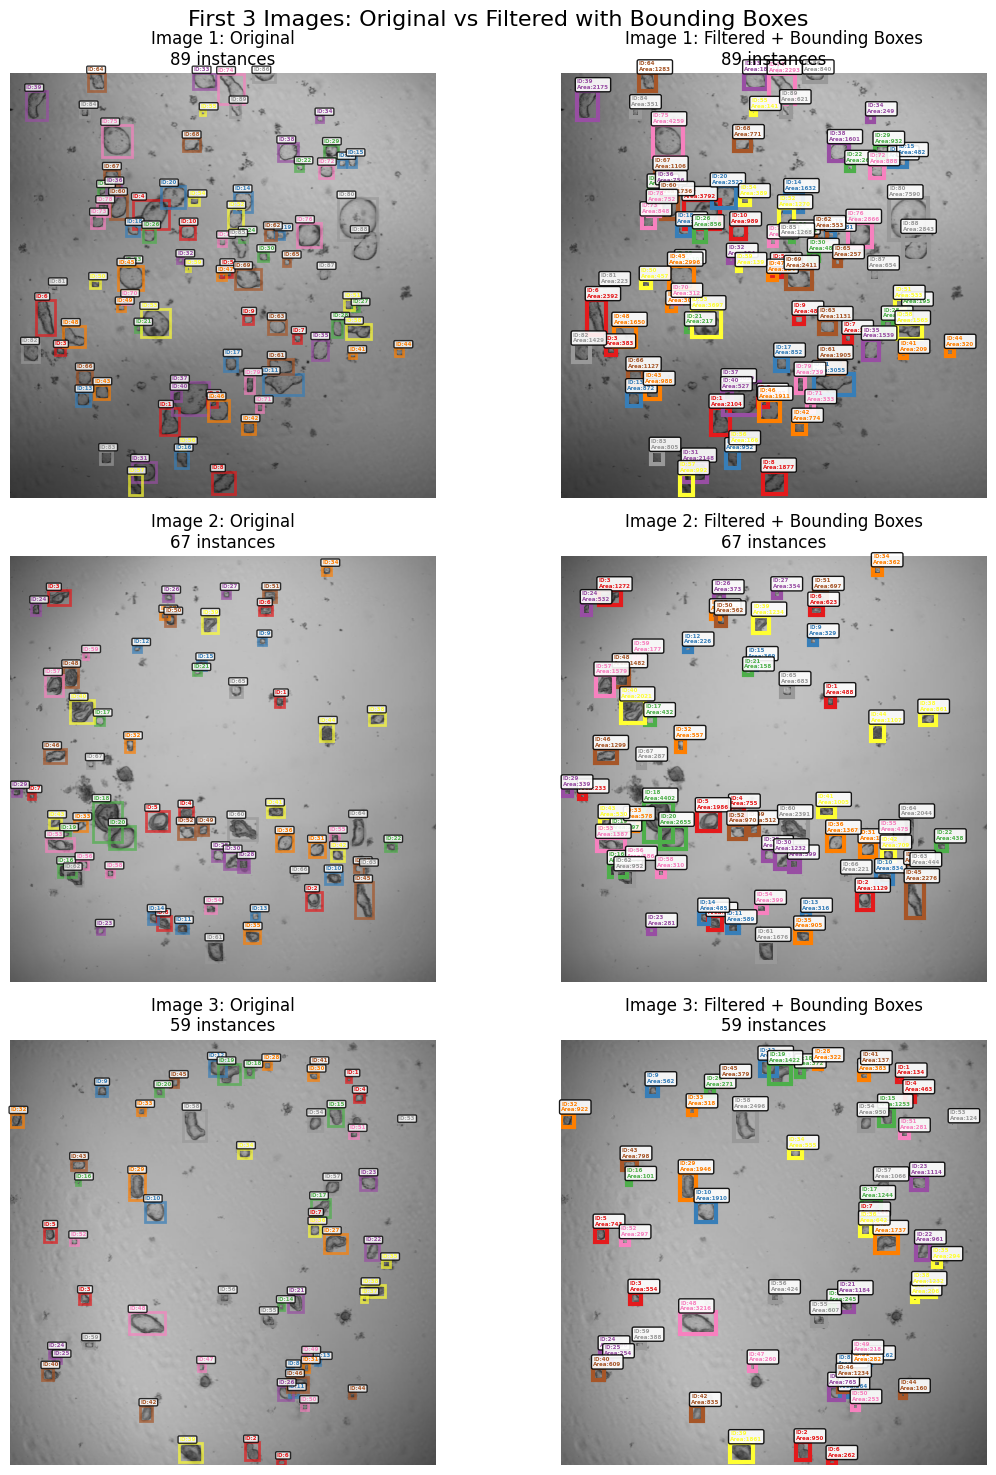


Detailed filtering comparison:

Detailed analysis for 0002_1141294_ckm3hgcub0fyg345zcgc2fous_img.jpg:
Original instance IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
Filtered instance IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]


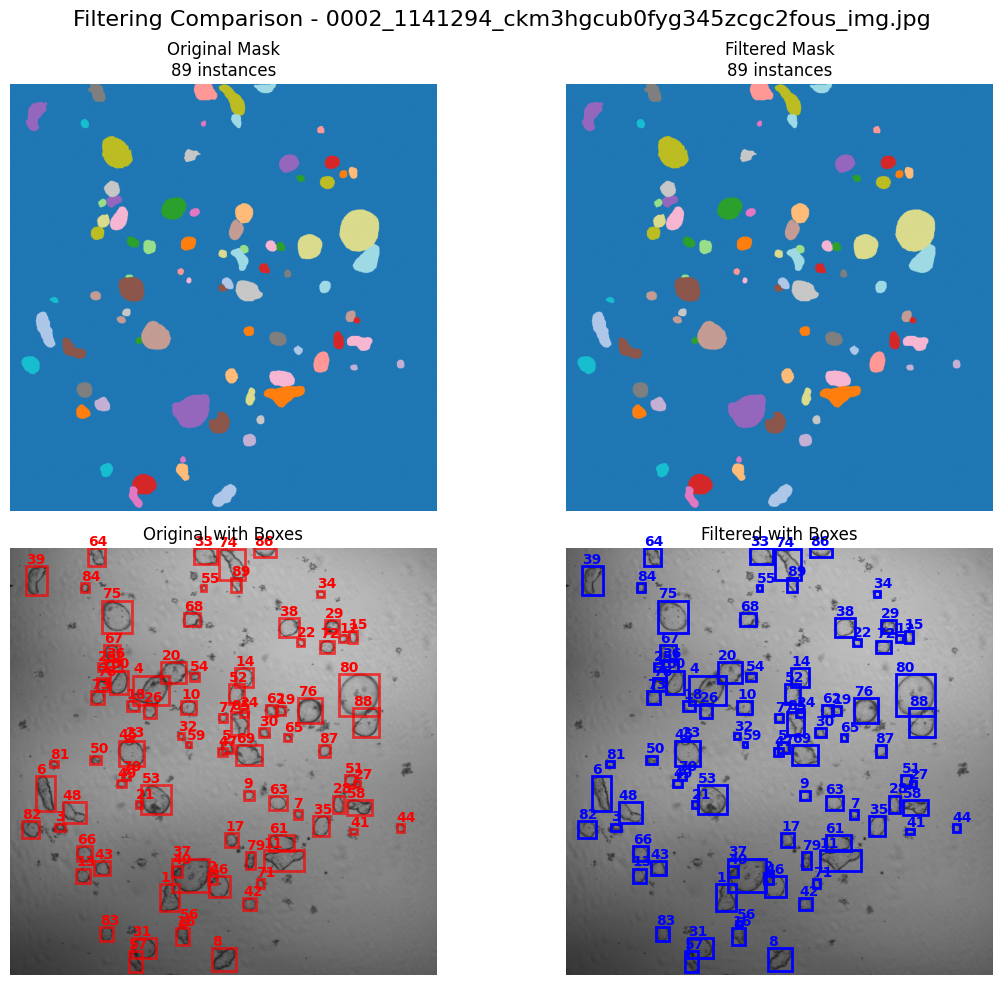

Instance 1: Original area 2104 -> Filtered area 2104
Instance 2: Original area 497 -> Filtered area 497
Instance 3: Original area 383 -> Filtered area 383
Instance 4: Original area 3792 -> Filtered area 3792
Instance 5: Original area 571 -> Filtered area 571
Instance 6: Original area 2392 -> Filtered area 2392
Instance 7: Original area 340 -> Filtered area 340
Instance 8: Original area 1877 -> Filtered area 1877
Instance 9: Original area 484 -> Filtered area 484
Instance 10: Original area 989 -> Filtered area 989
Instance 11: Original area 3055 -> Filtered area 3055
Instance 12: Original area 301 -> Filtered area 301
Instance 13: Original area 872 -> Filtered area 872
Instance 14: Original area 1632 -> Filtered area 1632
Instance 15: Original area 482 -> Filtered area 482
Instance 16: Original area 952 -> Filtered area 952
Instance 17: Original area 852 -> Filtered area 852
Instance 18: Original area 596 -> Filtered area 596
Instance 19: Original area 381 -> Filtered area 381
Instance 

In [7]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import ndimage

def filter_small_components(mask, min_area_ratio=0.5):
    """
    Filter out smaller disconnected components for each instance
    Keep only the largest connected component for each instance ID
    """
    filtered_mask = np.zeros_like(mask)
    unique_ids = np.unique(mask)[1:]  # exclude background (0)
    
    for instance_id in unique_ids:
        # Get binary mask for this instance
        binary_mask = (mask == instance_id).astype(np.uint8)
        
        # Find connected components
        num_labels, labels = cv2.connectedComponents(binary_mask)
        
        if num_labels > 1:  # More than just background
            # Calculate area of each component (excluding background label 0)
            component_areas = []
            for label in range(1, num_labels):
                area = np.sum(labels == label)
                component_areas.append((label, area))
            
            # Sort by area and keep only the largest
            component_areas.sort(key=lambda x: x[1], reverse=True)
            largest_label = component_areas[0][0]
            
            # Check if there are multiple components and filter small ones
            if len(component_areas) > 1:
                largest_area = component_areas[0][1]
                total_area = sum([area for _, area in component_areas])
                
                # Keep components that are at least min_area_ratio of the largest
                for label, area in component_areas:
                    if area >= largest_area * min_area_ratio:
                        filtered_mask[labels == label] = instance_id
                    else:
                        print(f"  Filtered small component: Instance {instance_id}, Component area {area} < {largest_area * min_area_ratio:.0f}")
            else:
                # Only one component, keep it
                filtered_mask[labels == largest_label] = instance_id
        elif num_labels == 1:
            # No components found (shouldn't happen)
            continue
    
    return filtered_mask

def read_images_and_labels(root_path, data_name, type_T):
    """Read images and mask labels, return data list"""
    images_path = os.path.join(root_path, data_name, type_T, 'images')
    masks_path = os.path.join(root_path, data_name, type_T, 'masks')

    data = []

    for image_name in os.listdir(images_path):
        if image_name.endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff')):
            image_path = os.path.join(images_path, image_name)
            
            base_name = os.path.splitext(image_name)[0]
            mask_extensions = ['.png', '.tif', '.tiff', '.jpg', '.jpeg']
            mask_path = None
            
            for ext in mask_extensions:
                potential_mask = os.path.join(masks_path, base_name + ext)
                if os.path.exists(potential_mask):
                    mask_path = potential_mask
                    break
            
            if mask_path:
                data.append({"image": image_path, "annotation": mask_path})

    return data

def read_batch_with_segmentation_masks(data):
    """Read random image and its instance segmentation masks with filtering"""
    
    ent = data[np.random.randint(len(data))]
    Img = cv2.imread(ent["image"])[..., ::-1]
    mask_img = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)
    
    if Img is None:
        raise ValueError(f"Cannot read image: {ent['image']}")
    if mask_img is None:
        raise ValueError(f"Cannot read mask: {ent['annotation']}")
    
    # Resize image and mask
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])
    new_width = int(Img.shape[1] * r)
    new_height = int(Img.shape[0] * r)
    
    Img = cv2.resize(Img, (new_width, new_height))
    mask_img = cv2.resize(mask_img, (new_width, new_height), interpolation=cv2.INTER_NEAREST)

    # Filter small disconnected components
    print(f"Processing: {os.path.basename(ent['image'])}")
    filtered_mask = filter_small_components(mask_img)

    # Get unique instance IDs after filtering
    inds = np.unique(filtered_mask)[1:]
    final_boxes = []
    final_masks = []
    
    for ind in inds:
        mask = (filtered_mask == ind).astype(np.uint8)
        final_masks.append(mask)
        
        coords = np.argwhere(mask > 0)
        if len(coords) > 0:
            ymin, xmin = coords.min(axis=0)
            ymax, xmax = coords.max(axis=0)
            final_boxes.append([xmin, ymin, xmax, ymax])

    return Img, np.array(final_masks), np.array(final_boxes)

def visualize_first_three_images(data):
    """Visualize the first 3 images with bounding boxes overlaid on original images"""
    
    fig, axes = plt.subplots(3, 2, figsize=(12, 15))
    fig.suptitle('First 3 Images: Original vs Filtered with Bounding Boxes', fontsize=16)
    
    for i in range(min(3, len(data))):
        ent = data[i]
        Img = cv2.imread(ent["image"])[..., ::-1]
        mask_img = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)
        
        if Img is None or mask_img is None:
            print(f"Cannot read image or mask: {ent['image']}")
            continue
            
        # Resize image and mask
        r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])
        new_width = int(Img.shape[1] * r)
        new_height = int(Img.shape[0] * r)
        
        Img_resized = cv2.resize(Img, (new_width, new_height))
        mask_resized = cv2.resize(mask_img, (new_width, new_height), interpolation=cv2.INTER_NEAREST)

        # Get original instances
        original_inds = np.unique(mask_resized)[1:]
        
        # Filter small components
        print(f"\nProcessing Image {i+1}: {os.path.basename(ent['image'])}")
        filtered_mask = filter_small_components(mask_resized)
        filtered_inds = np.unique(filtered_mask)[1:]
        
        # Calculate boxes for filtered instances
        final_boxes = []
        for ind in filtered_inds:
            mask = (filtered_mask == ind).astype(np.uint8)
            coords = np.argwhere(mask > 0)
            if len(coords) > 0:
                ymin, xmin = coords.min(axis=0)
                ymax, xmax = coords.max(axis=0)
                final_boxes.append([xmin, ymin, xmax, ymax, ind])  # Include instance ID

        # Plot 1: Original Image with Original Instances
        axes[i, 0].imshow(Img_resized)
        
        # Draw original instance boundaries
        colors = plt.cm.Set1(np.linspace(0, 1, max(1, len(original_inds))))
        for idx, ind in enumerate(original_inds):
            mask = (mask_resized == ind).astype(np.uint8)
            coords = np.argwhere(mask > 0)
            if len(coords) > 0:
                ymin, xmin = coords.min(axis=0)
                ymax, xmax = coords.max(axis=0)
                
                color = colors[idx] if len(original_inds) > 1 else 'red'
                rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                                       linewidth=2, edgecolor=color, facecolor='none', alpha=0.7)
                axes[i, 0].add_patch(rect)
                
                axes[i, 0].text(xmin, ymin-5, f'ID:{ind}', 
                              color=color, fontsize=4, fontweight='bold',
                              bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
        
        axes[i, 0].set_title(f'Image {i+1}: Original\n{len(original_inds)} instances')
        axes[i, 0].axis('off')
        
        # Plot 2: Filtered Image with Bounding Boxes
        axes[i, 1].imshow(Img_resized)
        
        # Draw filtered bounding boxes
        colors = plt.cm.Set1(np.linspace(0, 1, max(1, len(final_boxes))))
        for idx, (x_min, y_min, x_max, y_max, instance_id) in enumerate(final_boxes):
            width = x_max - x_min
            height = y_max - y_min
            
            color = colors[idx] if len(final_boxes) > 1 else 'red'
            
            rect = patches.Rectangle((x_min, y_min), width, height, 
                                   linewidth=3, edgecolor=color, facecolor='none')
            axes[i, 1].add_patch(rect)
            
            # Add instance ID and size info
            mask_area = np.sum(filtered_mask == instance_id)
            axes[i, 1].text(x_min, y_min-5, f'ID:{instance_id}\nArea:{mask_area}', 
                          color=color, fontsize=4, fontweight='bold',
                          bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))
        
        axes[i, 1].set_title(f'Image {i+1}: Filtered + Bounding Boxes\n{len(final_boxes)} instances')
        axes[i, 1].axis('off')
        
        # Print statistics
        print(f"  Original instances: {len(original_inds)} -> Filtered instances: {len(filtered_inds)}")
        if len(original_inds) != len(filtered_inds):
            removed_ids = set(original_inds) - set(filtered_inds)
            print(f"  Removed instance IDs: {removed_ids}")
        print(f"  Final boxes: {len(final_boxes)}")

    plt.tight_layout()
    plt.show()

def visualize_filtering_comparison(data, image_index=0):
    """Show detailed comparison of before and after filtering"""
    
    if image_index >= len(data):
        print(f"Image index {image_index} out of range. Dataset has {len(data)} images.")
        return
    
    ent = data[image_index]
    Img = cv2.imread(ent["image"])[..., ::-1]
    mask_img = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)
    
    if Img is None or mask_img is None:
        print(f"Cannot read image or mask: {ent['image']}")
        return
        
    # Resize
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])
    new_width = int(Img.shape[1] * r)
    new_height = int(Img.shape[0] * r)
    
    Img_resized = cv2.resize(Img, (new_width, new_height))
    mask_resized = cv2.resize(mask_img, (new_width, new_height), interpolation=cv2.INTER_NEAREST)

    # Get original and filtered masks
    original_inds = np.unique(mask_resized)[1:]
    print(f"\nDetailed analysis for {os.path.basename(ent['image'])}:")
    print(f"Original instance IDs: {list(original_inds)}")
    
    filtered_mask = filter_small_components(mask_resized)
    filtered_inds = np.unique(filtered_mask)[1:]
    print(f"Filtered instance IDs: {list(filtered_inds)}")
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original mask
    axes[0, 0].imshow(mask_resized, cmap='tab20')
    axes[0, 0].set_title(f'Original Mask\n{len(original_inds)} instances')
    axes[0, 0].axis('off')
    
    # Filtered mask
    axes[0, 1].imshow(filtered_mask, cmap='tab20')
    axes[0, 1].set_title(f'Filtered Mask\n{len(filtered_inds)} instances')
    axes[0, 1].axis('off')
    
    # Original image with original boxes
    axes[1, 0].imshow(Img_resized)
    for ind in original_inds:
        mask = (mask_resized == ind).astype(np.uint8)
        coords = np.argwhere(mask > 0)
        if len(coords) > 0:
            ymin, xmin = coords.min(axis=0)
            ymax, xmax = coords.max(axis=0)
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                                   linewidth=2, edgecolor='red', facecolor='none', alpha=0.7)
            axes[1, 0].add_patch(rect)
            axes[1, 0].text(xmin, ymin-5, f'{ind}', color='red', fontweight='bold')
    axes[1, 0].set_title('Original with Boxes')
    axes[1, 0].axis('off')
    
    # Filtered image with filtered boxes
    axes[1, 1].imshow(Img_resized)
    for ind in filtered_inds:
        mask = (filtered_mask == ind).astype(np.uint8)
        coords = np.argwhere(mask > 0)
        if len(coords) > 0:
            ymin, xmin = coords.min(axis=0)
            ymax, xmax = coords.max(axis=0)
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                                   linewidth=2, edgecolor='blue', facecolor='none')
            axes[1, 1].add_patch(rect)
            axes[1, 1].text(xmin, ymin-5, f'{ind}', color='blue', fontweight='bold')
    axes[1, 1].set_title('Filtered with Boxes')
    axes[1, 1].axis('off')
    
    plt.suptitle(f'Filtering Comparison - {os.path.basename(ent["image"])}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    for ind in original_inds:
        original_area = np.sum(mask_resized == ind)
        filtered_area = np.sum(filtered_mask == ind)
        print(f"Instance {ind}: Original area {original_area} -> Filtered area {filtered_area}")

# Usage
data_cls = ['Intestine', 'brain', 'colon', 'PDAC']
data_name = data_cls[0]
root_path = r'datasets'

data = read_images_and_labels(root_path, data_name, type_T='train')
print(f"Found {len(data)} images with annotations")

if len(data) > 0:
    # Show first 3 images with filtering
    visualize_first_three_images(data)
    
    # Show detailed comparison for first image
    print("\nDetailed filtering comparison:")
    visualize_filtering_comparison(data, image_index=0)
    
    # Test the read_batch function
    print("\nTesting filtered read_batch function:")
    image, mask, input_box = read_batch_with_segmentation_masks(data)
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Boxes shape: {input_box.shape}")
    print(f"Number of instances: {len(input_box)}")
else:
    print("No data found!")

In [11]:
# Load a SAM2 predictor with pre-trained weights.
# 
# Arguments:
#   model_name:    The specific model variant to use (e.g., "hiera_large").
#   config_dir:    The directory containing configuration files for SAM2.
# 
# Returns:
#   predictor:     An initialized predictor object ready for inference or fine-tuning.
from orgline.build_model import load_sam2_pretrained
predictor = load_sam2_pretrained(
    model_name="hiera_large",                 # Choose the model size/variant, e.g., "hiera_large"
    config_dir=r'orgline/sam2_configs',        # Path to the directory with config files
    download_dir=r'./',
    device='cuda:0'
)

Weight file size: 856.35 MB
Weight file sam2_hiera_large.pt already exists and verified
Loading model...
Model loaded successfully!


In [12]:
"""
OrgLineSeg Model Training Script

This script prepares data loaders and starts model training for the OrgLineSeg (SAM2-based) segmentation task.
It supports various configuration options, such as batch size, augmentation, learning rate, early stopping, etc.
The script will load the dataset, set up training and validation splits, and handle the training loop.

Requirements:
- The predictor object (e.g., SAM2 model) should be created and loaded beforehand.
- orgline.train_data.create_dataloaders and orgline.trainer.train_orglineseg_model must be available.

Author: Alex Deng
"""

# Create data loaders externally
from orgline.train_data import create_dataloaders
from orgline.trainer import train_orglineseg_model

# Define the dataset classes available
data_cls = ['Intestine', 'brain', 'colon', 'PDAC']
data_name = data_cls[0]  # Select the dataset to use (here: 'Intestine')
root_path = r'datasets'  # Path to the dataset root directory

# Create the training and validation data loaders.
# This function will:
#   - Read images and masks from the specified directory.
#   - Apply augmentations if requested (here: using albumentations).
#   - Return PyTorch DataLoader objects for training and validation.
train_loader, val_loader = create_dataloaders(
    root_path="datasets",
    data_name="Intestine", 
    type_T='train',            # Use the 'train' split
    batch_size=2,              # Number of samples per batch
    num_workers=0,             # Number of DataLoader worker processes
    image_size=512,            # Resize images to 512x512
    max_instances=16,          # Max number of instances per image
    train_augment=True,        # Enable training data augmentation
    train_size=0.8,            # Training/validation split ratio
    use_albumentations=True,   # Use albumentations for augmentation
    disable_augment_after_epoch=15   # Disable augmentation after 15 epochs
)

# You can also specify a custom training configuration.
custom_config = {
    'num_epochs': 300,          # Number of training epochs
    'lr': 1e-4,                # Learning rate
    'accumulate_steps': 4,     # Gradient accumulation steps
    'patience': 1000,          # Early stopping patience (steps)
    'gamma': 0.995,             # Learning rate decay factor (ExponentialLR)
    'validate_every':50
}

# Start model training.
# This function will:
#   - Train the model using the data loaders and configuration.
#   - Perform validation, checkpointing, and early stopping as needed.
#   - Return a dictionary with training results and statistics.
results = train_orglineseg_model(
    predictor=predictor,       # The SAM2 predictor/model to train
    train_loader=train_loader,
    val_loader=val_loader,
    config=custom_config ,      # Pass custom training configuration
    device='cuda:0',

)

print(f"Training results: {results}")

Training samples: 147
Validation samples: 37
Batch size: 8
Max instances per image: 16
Image size: 512
Using albumentations: True
Data augmentation will be disabled after epoch 15
Starting training for 30 epochs (570 steps)
Configuration: {'num_epochs': 30, 'lr': 0.0001, 'weight_decay': 4e-05, 'gamma': 0.995, 'patience': 1000, 'validation_samples': 50, 'checkpoint_every': 1000, 'validate_every': 500, 'cleanup_every': 30, 'accumulate_steps': 4}
Initial GPU memory: 0.84GB allocated, 1.76GB cached
Epoch 0: Using data augmentation


Epoch 1/30: 100%|██████████████████████████████████| 19/19 [00:23<00:00,  1.25s/it, Loss=0.0025, IoU=0.857, Objs=48, LR=9.14e-05, GPU=0.8GB]


Epoch 1 completed: Avg Loss = 0.0026, Avg IoU = 0.8754, GPU Memory = 1.02GB
Epoch 1: Using data augmentation


Epoch 2/30: 100%|██████████████████████████████████| 19/19 [00:30<00:00,  1.61s/it, Loss=0.0019, IoU=0.888, Objs=48, LR=8.31e-05, GPU=1.0GB]


Epoch 2 completed: Avg Loss = 0.0022, Avg IoU = 0.8852, GPU Memory = 1.02GB
Epoch 2: Using data augmentation


Epoch 3/30: 100%|██████████████████████████████████| 19/19 [00:31<00:00,  1.68s/it, Loss=0.0015, IoU=0.896, Objs=43, LR=7.55e-05, GPU=1.0GB]


Epoch 3 completed: Avg Loss = 0.0021, Avg IoU = 0.8862, GPU Memory = 1.02GB
Epoch 3: Using data augmentation


Epoch 4/30: 100%|██████████████████████████████████| 19/19 [00:31<00:00,  1.67s/it, Loss=0.0018, IoU=0.888, Objs=48, LR=6.87e-05, GPU=1.0GB]


Epoch 4 completed: Avg Loss = 0.0020, Avg IoU = 0.8870, GPU Memory = 1.02GB
Epoch 4: Using data augmentation


Epoch 5/30: 100%|██████████████████████████████████| 19/19 [00:27<00:00,  1.47s/it, Loss=0.0017, IoU=0.892, Objs=48, LR=6.24e-05, GPU=1.0GB]


Epoch 5 completed: Avg Loss = 0.0020, Avg IoU = 0.8909, GPU Memory = 1.02GB
Epoch 5: Using data augmentation


Epoch 6/30: 100%|██████████████████████████████████| 19/19 [00:31<00:00,  1.65s/it, Loss=0.0015, IoU=0.882, Objs=48, LR=5.68e-05, GPU=1.0GB]


Epoch 6 completed: Avg Loss = 0.0019, Avg IoU = 0.8902, GPU Memory = 1.02GB
Epoch 6: Using data augmentation


Epoch 7/30: 100%|██████████████████████████████████| 19/19 [00:23<00:00,  1.24s/it, Loss=0.0018, IoU=0.896, Objs=48, LR=5.16e-05, GPU=1.0GB]


Epoch 7 completed: Avg Loss = 0.0019, Avg IoU = 0.8907, GPU Memory = 1.02GB
Epoch 7: Using data augmentation


Epoch 8/30: 100%|██████████████████████████████████| 19/19 [00:22<00:00,  1.17s/it, Loss=0.0016, IoU=0.893, Objs=48, LR=4.69e-05, GPU=1.0GB]


Epoch 8 completed: Avg Loss = 0.0018, Avg IoU = 0.8958, GPU Memory = 1.02GB
Epoch 8: Using data augmentation


Epoch 9/30: 100%|██████████████████████████████████| 19/19 [00:22<00:00,  1.20s/it, Loss=0.0021, IoU=0.886, Objs=43, LR=4.27e-05, GPU=1.0GB]


Epoch 9 completed: Avg Loss = 0.0018, Avg IoU = 0.8947, GPU Memory = 1.02GB
Epoch 9: Using data augmentation


Epoch 10/30: 100%|█████████████████████████████████| 19/19 [00:25<00:00,  1.33s/it, Loss=0.0017, IoU=0.879, Objs=48, LR=3.88e-05, GPU=1.0GB]


Epoch 10 completed: Avg Loss = 0.0018, Avg IoU = 0.8933, GPU Memory = 1.02GB
Epoch 10: Using data augmentation


Epoch 11/30: 100%|█████████████████████████████████| 19/19 [00:31<00:00,  1.66s/it, Loss=0.0018, IoU=0.894, Objs=48, LR=3.53e-05, GPU=1.0GB]


Epoch 11 completed: Avg Loss = 0.0017, Avg IoU = 0.8966, GPU Memory = 1.02GB
Epoch 11: Using data augmentation


Epoch 12/30: 100%|█████████████████████████████████| 19/19 [00:32<00:00,  1.74s/it, Loss=0.0014, IoU=0.888, Objs=48, LR=3.21e-05, GPU=1.0GB]


Epoch 12 completed: Avg Loss = 0.0019, Avg IoU = 0.8916, GPU Memory = 1.02GB
Epoch 12: Using data augmentation


Epoch 13/30: 100%|█████████████████████████████████| 19/19 [00:32<00:00,  1.69s/it, Loss=0.0014, IoU=0.906, Objs=48, LR=2.91e-05, GPU=1.0GB]


Epoch 13 completed: Avg Loss = 0.0018, Avg IoU = 0.8954, GPU Memory = 1.02GB
Epoch 13: Using data augmentation


Epoch 14/30: 100%|█████████████████████████████████| 19/19 [00:29<00:00,  1.53s/it, Loss=0.0016, IoU=0.898, Objs=48, LR=2.65e-05, GPU=1.0GB]


Epoch 14 completed: Avg Loss = 0.0018, Avg IoU = 0.8915, GPU Memory = 1.02GB
Epoch 14: Using data augmentation


Epoch 15/30: 100%|█████████████████████████████████| 19/19 [00:32<00:00,  1.70s/it, Loss=0.0022, IoU=0.893, Objs=48, LR=2.41e-05, GPU=1.0GB]


Epoch 15 completed: Avg Loss = 0.0017, Avg IoU = 0.8934, GPU Memory = 1.02GB
Epoch 15: Data augmentation disabled


Epoch 16/30: 100%|█████████████████████████████████| 19/19 [00:30<00:00,  1.59s/it, Loss=0.0018, IoU=0.911, Objs=48, LR=2.19e-05, GPU=1.0GB]


Epoch 16 completed: Avg Loss = 0.0015, Avg IoU = 0.9088, GPU Memory = 1.02GB
Epoch 16: Data augmentation disabled


Epoch 17/30: 100%|█████████████████████████████████| 19/19 [00:29<00:00,  1.58s/it, Loss=0.0019, IoU=0.911, Objs=48, LR=1.99e-05, GPU=1.0GB]


Epoch 17 completed: Avg Loss = 0.0015, Avg IoU = 0.9103, GPU Memory = 1.02GB
Epoch 17: Data augmentation disabled


Epoch 18/30: 100%|█████████████████████████████████| 19/19 [00:30<00:00,  1.58s/it, Loss=0.0013, IoU=0.908, Objs=48, LR=1.81e-05, GPU=1.0GB]


Epoch 18 completed: Avg Loss = 0.0015, Avg IoU = 0.9122, GPU Memory = 1.02GB
Epoch 18: Data augmentation disabled


Epoch 19/30: 100%|█████████████████████████████████| 19/19 [00:30<00:00,  1.59s/it, Loss=0.0014, IoU=0.910, Objs=48, LR=1.65e-05, GPU=1.0GB]


Epoch 19 completed: Avg Loss = 0.0014, Avg IoU = 0.9122, GPU Memory = 1.02GB
Epoch 19: Data augmentation disabled


Epoch 20/30: 100%|█████████████████████████████████| 19/19 [00:30<00:00,  1.60s/it, Loss=0.0013, IoU=0.908, Objs=48, LR=1.50e-05, GPU=1.0GB]


Epoch 20 completed: Avg Loss = 0.0014, Avg IoU = 0.9121, GPU Memory = 1.02GB
Epoch 20: Data augmentation disabled


Epoch 21/30: 100%|█████████████████████████████████| 19/19 [00:25<00:00,  1.35s/it, Loss=0.0015, IoU=0.922, Objs=48, LR=1.36e-05, GPU=1.0GB]


Epoch 21 completed: Avg Loss = 0.0014, Avg IoU = 0.9127, GPU Memory = 1.02GB
Epoch 21: Data augmentation disabled


Epoch 22/30: 100%|█████████████████████████████████| 19/19 [00:22<00:00,  1.17s/it, Loss=0.0017, IoU=0.908, Objs=48, LR=1.24e-05, GPU=1.0GB]


Epoch 22 completed: Avg Loss = 0.0014, Avg IoU = 0.9122, GPU Memory = 1.02GB
Epoch 22: Data augmentation disabled


Epoch 23/30: 100%|█████████████████████████████████| 19/19 [00:22<00:00,  1.18s/it, Loss=0.0011, IoU=0.910, Objs=48, LR=1.12e-05, GPU=1.0GB]


Epoch 23 completed: Avg Loss = 0.0013, Avg IoU = 0.9130, GPU Memory = 1.02GB
Epoch 23: Data augmentation disabled


Epoch 24/30: 100%|█████████████████████████████████| 19/19 [00:27<00:00,  1.46s/it, Loss=0.0018, IoU=0.920, Objs=48, LR=1.02e-05, GPU=1.0GB]


Epoch 24 completed: Avg Loss = 0.0013, Avg IoU = 0.9127, GPU Memory = 1.02GB
Epoch 24: Data augmentation disabled


Epoch 25/30: 100%|█████████████████████████████████| 19/19 [00:29<00:00,  1.58s/it, Loss=0.0011, IoU=0.900, Objs=48, LR=9.29e-06, GPU=1.0GB]


Epoch 25 completed: Avg Loss = 0.0013, Avg IoU = 0.9124, GPU Memory = 1.02GB
Epoch 25: Data augmentation disabled


Epoch 26/30: 100%|█████████████████████████████████| 19/19 [00:29<00:00,  1.57s/it, Loss=0.0018, IoU=0.914, Objs=48, LR=8.45e-06, GPU=1.0GB]


Epoch 26 completed: Avg Loss = 0.0013, Avg IoU = 0.9124, GPU Memory = 1.02GB
Epoch 26: Data augmentation disabled


Epoch 27/30:  26%|████████▋                        | 5/19 [00:10<00:23,  1.71s/it, Loss=0.0013, IoU=0.907, Objs=128, LR=8.20e-06, GPU=1.0GB]


Step 500: Validation IoU = 0.8839


Epoch 27/30:  32%|██████████▍                      | 6/19 [00:22<01:18,  6.02s/it, Loss=0.0013, IoU=0.907, Objs=128, LR=8.20e-06, GPU=1.0GB]

New best model saved with IoU: 0.8839


Epoch 27/30: 100%|█████████████████████████████████| 19/19 [00:37<00:00,  1.99s/it, Loss=0.0011, IoU=0.908, Objs=48, LR=7.68e-06, GPU=1.0GB]


Epoch 27 completed: Avg Loss = 0.0013, Avg IoU = 0.9137, GPU Memory = 1.02GB
Epoch 27: Data augmentation disabled


Epoch 28/30: 100%|█████████████████████████████████| 19/19 [00:28<00:00,  1.49s/it, Loss=0.0010, IoU=0.901, Objs=48, LR=6.98e-06, GPU=1.0GB]


Epoch 28 completed: Avg Loss = 0.0013, Avg IoU = 0.9135, GPU Memory = 1.02GB
Epoch 28: Data augmentation disabled


Epoch 29/30: 100%|█████████████████████████████████| 19/19 [00:30<00:00,  1.60s/it, Loss=0.0010, IoU=0.907, Objs=48, LR=6.35e-06, GPU=1.0GB]


Epoch 29 completed: Avg Loss = 0.0013, Avg IoU = 0.9133, GPU Memory = 1.02GB
Epoch 29: Data augmentation disabled


Epoch 30/30: 100%|█████████████████████████████████| 19/19 [00:30<00:00,  1.58s/it, Loss=0.0012, IoU=0.913, Objs=48, LR=5.77e-06, GPU=1.0GB]


Epoch 30 completed: Avg Loss = 0.0013, Avg IoU = 0.9137, GPU Memory = 1.02GB
Training completed!
Best validation IoU: 0.8839
Training results: {'best_val_iou': 0.8838775592881281, 'final_epoch': 30, 'total_steps': 570, 'status': 'completed'}
